# ClimateBert

by Harsh Vardhan Pachisia



Links used:
1. https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270
2. https://towardsdatascience.com/part-1-data-cleaning-does-bert-need-clean-data-6a50c9c6e9fd
3. https://towardsdatascience.com/does-bert-need-clean-data-part-2-classification-d29adf9f745a
4. https://huggingface.co/climatebert/distilroberta-base-climate-sentiment
5. https://ai.plainenglish.io/bert-pytorch-implementation-prepare-dataset-part-1-efd259113e5a

In [1]:
import pandas as pd
from google.colab import drive


In [2]:
# Mount GDrive
drive.mount("/content/drive")


Mounted at /content/drive


In [3]:
data_path = "/content/drive/Shareddrives/adv-ml-project/Data/"
# took the filtered comments that Santi had done to make preprocessing easier
filtered_comments = pd.read_csv(data_path + "comments_filtered.csv")

In [12]:
filtered_comments.head()

,subreddit.name,date,body,sentiment,label
0,askreddit,2022-08-31 23:56:46,I think climate change tends to get some peopl...,0.6634,1.0
1,askreddit,2022-08-31 23:54:25,They need to change laws so it's more worth se...,0.4690,1.0
2,askreddit,2022-08-31 23:52:41,That a big part of the solution to climate cha...,0.8937,1.0
3,askreddit,2022-08-31 23:49:45,&gt;Not climate change mind you\n\nHi. I have ...,0.0000,0.0
4,worldnews,2022-08-31 23:48:15,"Climate change is not ""staring"" you in the fac...",-0.3453,-1.0


In [6]:
filtered_comments.shape
# has close to a million records

(912357, 5)

In [7]:
filtered_comments.describe(include='all')
# so we have 26 subreddits, some duplicate text

,subreddit.name,date,body,sentiment,label
count,912357,912349,912349,892303.000000,912319.000000
unique,26,908243,890139,NaN,NaN
top,politics,2020-10-08 01:44:41,Climate change,NaN,NaN
freq,339167,5,6094,NaN,NaN
mean,NaN,NaN,NaN,-0.047641,-0.040435
std,NaN,NaN,NaN,0.639994,0.954535
min,NaN,NaN,NaN,-0.999900,-1.000000
25%,NaN,NaN,NaN,-0.652100,-1.000000
50%,NaN,NaN,NaN,0.000000,0.000000
75%,NaN,NaN,NaN,0.542300,1.000000


In [5]:
# Ensure text is a string
filtered_comments['body'] = str(filtered_comments['body'])

### Cleaning body column
Removing URLs, punctuation and special characters in each comment and converting them all to lowercase.

Preprocessing is not needed when using pre-trained language representation models like BERT.
In particular, it uses all of the information in a sentence, even punctuation and stop-words,from a wide range of perspectives by leveraging a multi-head self attention mechanism.
so might not be needed.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\S*@\S*\s?', '', text)  # Remove emails and mentions
    #text = re.sub(r'[\d]', '', text)  # Remove numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[\.\,\'\"\!\?\:\;\-\_]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

filtered_comments['body'] = filtered_comments['body'].apply(clean_text)
filtered_comments

## Climate Bert model

https://huggingface.co/climatebert/distilroberta-base-climate-sentiment

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("climatebert/distilroberta-base-climate-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("climatebert/distilroberta-base-climate-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/947 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [11]:
sample_size = 100000 #100,000 body

# Take a random sample of the dataset
sampled_comments = filtered_comments.sample(n=sample_size, random_state=56)

In [12]:
# Apply the same tokenization process on this smaller dataset
batch_size = 16  # Setting the batch size
encoded_inputs = []

for i in range(0, len(sampled_comments['body']), batch_size):
    batch = sampled_comments['body'][i:i+batch_size].tolist()
    encoded_batch = tokenizer(batch, return_tensors='pt', padding='max_length',
                              max_length=512, truncation=True)
    encoded_inputs.append(encoded_batch)

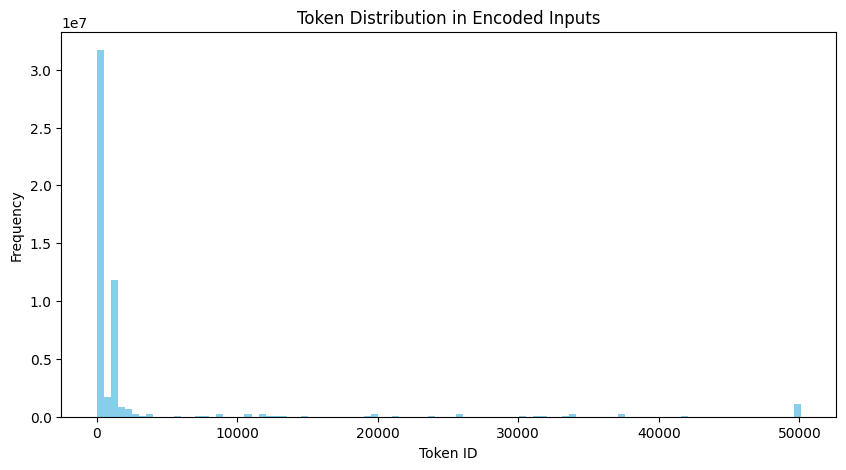

In [13]:
import matplotlib.pyplot as plt
import numpy as np
# Flatten the array of token IDs to get the distribution
flattened_token_ids = np.concatenate([batch['input_ids'].numpy().flatten() for batch in encoded_inputs])

plt.figure(figsize=(10, 5))
plt.hist(flattened_token_ids, bins=100, color='skyblue')
plt.title('Token Distribution in Encoded Inputs')
plt.xlabel('Token ID')
plt.ylabel('Frequency')
plt.show()

High Frequency of Specific Tokens: The tallest bars at the beginning of the x-axis indicate that there are a few tokens with very high frequency. These are likely to be very common words or symbols, or they could be special tokens like padding tokens.


In [ ]:
# Iterate over the dataset in batches
for i in range(0, len(filtered_comments['body']), batch_size):
    # put all body into batches for preprocessing as Bert needs
    batch = filtered_comments['body'][i:i+batch_size].tolist()  # Extract the batch
    #preprocess the text
    encoded_batch = tokenizer(batch, return_tensors='pt', padding='max_length',
                              max_length = 256, truncation=True)
    encoded_inputs.append(encoded_batch)  # Store the tokenized batch